## Timeseries Data

Go over using Time Series MongoDB collections by scraping stock market data over the internet

##### Install Dependencies In Terminal (if you do not already have it)
```bash
pip install --user yfinance
pip install --user matplotlib
```

In [1]:
from pymongo import MongoClient

import pandas
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

### Intro to yfinance

In [2]:
tickers = ["AMZN", "GOOGL"]
data = yf.download(tickers=tickers, period="1y", interval="1d")

[*********************100%***********************]  2 of 2 completed


In [3]:
print(type(data))
data[0:3]

<class 'pandas.core.frame.DataFrame'>


Adj Close                     Close                      High  \
                   AMZN        GOOGL         AMZN        GOOGL         AMZN   
Date                                                                          
2021-01-22  3292.229980  1892.560059  3292.229980  1892.560059  3321.909912   
2021-01-25  3294.000000  1894.280029  3294.000000  1894.280029  3363.889893   
2021-01-26  3326.129883  1907.949951  3326.129883  1907.949951  3338.000000   

                                 Low                      Open               \
                  GOOGL         AMZN        GOOGL         AMZN        GOOGL   
Date                                                                          
2021-01-22  1904.390015  3283.159912  1876.500000  3304.310059  1891.459961   
2021-01-25  1921.819946  3243.149902  1859.160034  3328.500000  1912.739990   
2021-01-26  1915.750000  3282.870117  1876.130005  3296.360107  1885.989990   

             Volume           
               AMZN    GOOGL  
Date                          
2021-01-22  2821900  1637200  
2021-01-25  3749800  2529300  
2021-01-26  2955200  1573100

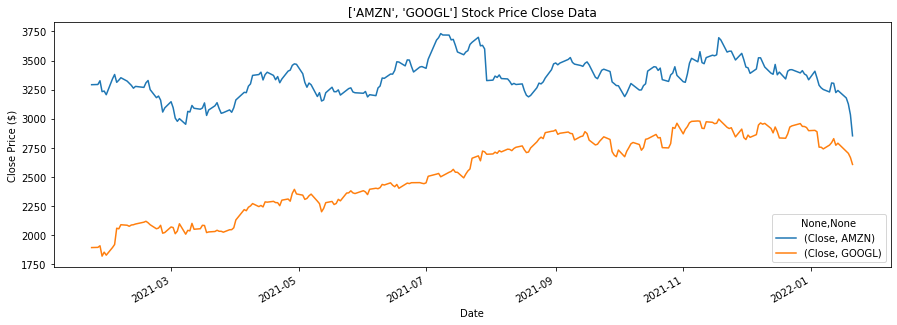

In [4]:
ax = data.plot(y=["Close"], figsize=(15, 5), title=str(tickers) + " Stock Price Close Data")
ax.set_ylabel("Close Price ($)")
None

### Converting yfinance dataframe to dict format for insertion

##### Swap the columns so the ticker names are the highest level column

In [5]:
data.columns = data.columns.swaplevel(0,1)
data[0:3]

,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL,AMZN,GOOGL
,Adj Close,Adj Close,Close,Close,High,High,Low,Low,Open,Open,Volume,Volume
Date,,,,,,,,,,,,
2021-01-22,3292.229980,1892.560059,3292.229980,1892.560059,3321.909912,1904.390015,3283.159912,1876.500000,3304.310059,1891.459961,2821900,1637200
2021-01-25,3294.000000,1894.280029,3294.000000,1894.280029,3363.889893,1921.819946,3243.149902,1859.160034,3328.500000,1912.739990,3749800,2529300
2021-01-26,3326.129883,1907.949951,3326.129883,1907.949951,3338.000000,1915.750000,3282.870117,1876.130005,3296.360107,1885.989990,2955200,1573100


In [6]:
data["AMZN"][0:3]

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2021-01-22,3292.229980,3292.229980,3321.909912,3283.159912,3304.310059,2821900
2021-01-25,3294.000000,3294.000000,3363.889893,3243.149902,3328.500000,3749800
2021-01-26,3326.129883,3326.129883,3338.000000,3282.870117,3296.360107,2955200


##### Create an attribute an each entry that has the name of the ticker

In [7]:
for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker

In [8]:
data["GOOGL"][0:3]

,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
2021-01-22,1892.560059,1892.560059,1904.390015,1876.500000,1891.459961,1637200,GOOGL
2021-01-25,1894.280029,1894.280029,1921.819946,1859.160034,1912.739990,2529300,GOOGL
2021-01-26,1907.949951,1907.949951,1915.750000,1876.130005,1885.989990,1573100,GOOGL


##### Set date index to a column 

In [9]:
data["AMZN"].reset_index(level=0)[0:3]

,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
0,2021-01-22,3292.229980,3292.229980,3321.909912,3283.159912,3304.310059,2821900,AMZN
1,2021-01-25,3294.000000,3294.000000,3363.889893,3243.149902,3328.500000,3749800,AMZN
2,2021-01-26,3326.129883,3326.129883,3338.000000,3282.870117,3296.360107,2955200,AMZN


##### Convert the dataframe to an array of dictionaries 

In [10]:
data["AMZN"].reset_index(level=0).to_dict('records')[0:2]

[{'Date': Timestamp('2021-01-22 00:00:00'),
  'Adj Close': 3292.22998046875,
  'Close': 3292.22998046875,
  'High': 3321.909912109375,
  'Low': 3283.159912109375,
  'Open': 3304.31005859375,
  'Volume': 2821900,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2021-01-25 00:00:00'),
  'Adj Close': 3294.0,
  'Close': 3294.0,
  'High': 3363.889892578125,
  'Low': 3243.14990234375,
  'Open': 3328.5,
  'Volume': 3749800,
  'Ticker': 'AMZN'}]

### Connect To MongoDB instance

In [11]:
mongodb_uri = "mongodb://localhost:27017/"
db_name = "advanced_features"

In [12]:
client = MongoClient(mongodb_uri)
db = client[db_name]

### Creating  A Time-Series Collection

You could also use the compass app or mongoshell

In [13]:
db.create_collection("historical_stock_data", timeseries= {
        "timeField": "Date",
        "metaField": "Ticker",
        "granularity": "hours"
        }, expireAfterSeconds= 60 * 60 * 24 * 365 ### 1 year 
)

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'advanced_features'), 'historical_stock_data')

### Inserting The Time-Series Stock Data

##### Download the data

In [14]:
tickers = ["AMZN", "FB", "GOOGL", "MSFT", "UDMY"]
data = yf.download(tickers=tickers, period="2y", interval="1d")

[*********************100%***********************]  5 of 5 completed


##### Process dataframe into list of dictionaries

In [15]:
stock_data_to_insert = []

data.columns = data.columns.swaplevel(0,1)

for ticker in tickers:
    data.loc[: , (ticker, "Ticker")] = ticker
    stock_data_to_insert.extend(data[ticker].reset_index(level=0).to_dict('records'))

In [16]:
stock_data_to_insert[0:2]

[{'Date': Timestamp('2020-01-22 00:00:00'),
  'Adj Close': 1887.4599609375,
  'Close': 1887.4599609375,
  'High': 1902.5,
  'Low': 1883.3399658203125,
  'Open': 1896.0899658203125,
  'Volume': 3216300,
  'Ticker': 'AMZN'},
 {'Date': Timestamp('2020-01-23 00:00:00'),
  'Adj Close': 1884.5799560546875,
  'Close': 1884.5799560546875,
  'High': 1889.97998046875,
  'Low': 1872.760009765625,
  'Open': 1885.1099853515625,
  'Volume': 2484600,
  'Ticker': 'AMZN'}]

##### Call insert_many() on time series collection

In [17]:
db.historical_stock_data.insert_many(stock_data_to_insert)

### Retrieving Time-Series Data

In [18]:
gt_date = datetime.now() - relativedelta(months=6)
gt_date

datetime.datetime(2021, 7, 23, 14, 36, 59, 909872)

In [19]:
ts_cursor = db.historical_stock_data.find({"Ticker": "FB", "Date": {"$gte": gt_date} })

fb_price_data = []

for entry in ts_cursor:
    fb_price_data.append(entry)
    
print(fb_price_data[0:2])

[{'Date': datetime.datetime(2021, 7, 26, 0, 0), 'Ticker': 'FB', '_id': ObjectId('61edf4a8d729e28e8d60b435'), 'Adj Close': 372.4599914550781, 'Open': 369.5799865722656, 'Close': 372.4599914550781, 'High': 374.44000244140625, 'Low': 368.2200012207031, 'Volume': 14925200}, {'Date': datetime.datetime(2021, 7, 27, 0, 0), 'Ticker': 'FB', '_id': ObjectId('61edf4a8d729e28e8d60b436'), 'Adj Close': 367.80999755859375, 'Open': 371.9100036621094, 'Close': 367.80999755859375, 'High': 373.1499938964844, 'Low': 364.54998779296875, 'Volume': 15705400}]


In [20]:
read_in_data = pandas.DataFrame(fb_price_data)
read_in_data = read_in_data.set_index("Date")
read_in_data = read_in_data.drop("_id", axis=1)

read_in_data

,Ticker,Adj Close,Open,Close,High,Low,Volume
Date,,,,,,,
2021-07-26,FB,372.459991,369.579987,372.459991,374.440002,368.220001,14925200
2021-07-27,FB,367.809998,371.910004,367.809998,373.149994,364.549988,15705400
2021-07-28,FB,373.279999,374.559998,373.279999,377.549988,366.929993,29676900
2021-07-29,FB,358.320007,361.000000,358.320007,365.519989,356.739990,33413200
2021-07-30,FB,356.299988,354.000000,356.299988,360.730011,352.940002,15966700
...,...,...,...,...,...,...,...
2022-01-14,FB,331.899994,321.790009,331.899994,332.730011,321.209991,16853900
2022-01-18,FB,318.149994,323.290009,318.149994,324.209991,317.640015,22645600
2022-01-19,FB,319.589996,319.579987,319.589996,327.100006,319.329987,20814700
